In [1]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os, sys

from pykern.pkcollections import PKDict
from pykern import pkdebug

# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser
from rslaser.rspulse import pulse, gauss_hermite
from rslaser.utils import plot_fields, constants

import scipy

# reset the notebook style
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

In [2]:
# specify all top-level input parameters

# central values
a0 = 0.01             # 0.85e-9 * lambda [microns] * Sqrt(Intensity [W/cm^2])
lambda0 = 8.e-7       # wavelength [m]
tau_fwhm = 1.e-10     # FWHM pulse length [s]
w0 = 400.e-6          # waist size [m]
z_waist = 0.0         # longitudinal waist position [m]
z_center = 0.0        # longitudinal position of pulse center [m]

# deviations
d_lambda = 0.         # full wavelength chirp across laser pulse [m]
dw0x = 0.0            # deviation of horizontal waist from w0
dw0y = 0.0            # deviation of vertical waist from w0
dzwx = 0.0            # deviation of horizontal waist position from z_waist
dzwy = 0.0            # deviation of vertical waist position from z_waist
x_shift = 0.          # bulk horizontal shift of pulse position
y_shift = 0.          # bulk vertical shift of pulse position

# numerical values
num_slices = 3        # desired number of slices (i.e. SRW wavefronts) to represent the pulse

# other DERIVED quantities
d_to_w = z_waist - z_center   # so-called 'drift to waist' (required by SRW)

In [3]:
# create a dictionary of all relevant physical and numerical quantities
data_in=PKDict()

data_in.a0 = a0
data_in.lambda0 = lambda0
data_in.tau_fwhm = tau_fwhm
data_in.w0 = w0
data_in.z_waist = z_waist
data_in.z_center = z_center
data_in.d_to_w = z_waist - z_center

data_in.d_lambda = d_lambda
data_in.dw0x = dw0x
data_in.dw0y = dw0y
data_in.dzwx = dzwx
data_in.dzwy = dzwy
data_in.x_shift = x_shift
data_in.y_shift = y_shift

data_in.nslice = num_slices


In [4]:
# instantiate the laser pulse (takes a few seconds)
LP = pulse.LaserPulse(data_in)

In [5]:
# specify the desired plots
plot_2d_zy_explicit = True
plot_2d_zy_envelope = True
plot_1d_z_explicit = True
plot_1d_z_envelope = True
plot_2d_zr_explicit = True
plot_2d_zr_envelope = True

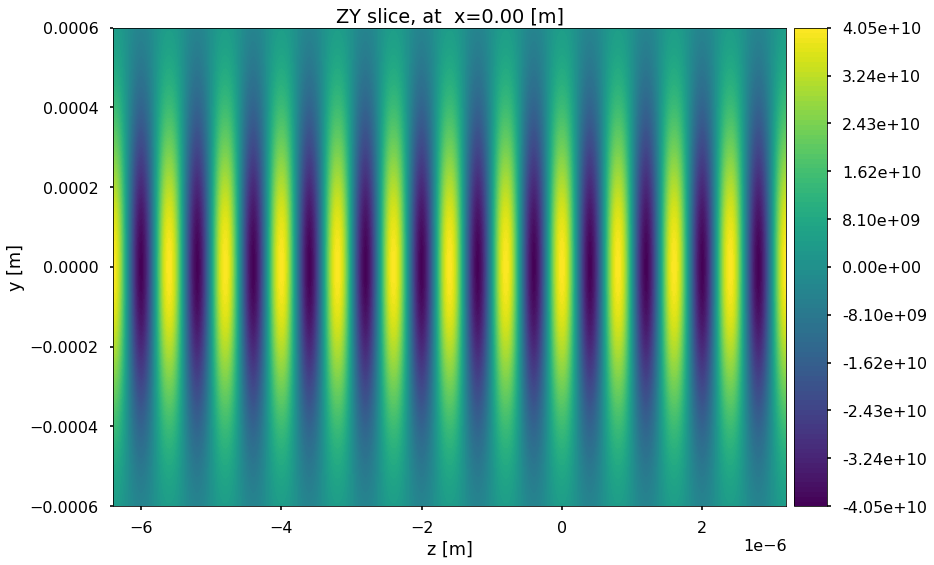

In [6]:
# plot fields in a z-y plane that intersects the x=0 axis
# we are assuming linear polarization along the x-axis

# Turn on print statements for a particular file, a specified module, or *all* rslaser modules
#pkdebug.init(control='gauss_hermite.py')
#pkdebug.init(control='rspulse')
#pkdebug.init(control='rslaser')

if plot_2d_zy_explicit:
    
    # longitudinal resolution
    hres = 64
    dh = LP.envelope.lambda0 / hres

    # specify the horizontal min's and max's
    zyMinH = -8. * LP.envelope.lambda0
    zyMaxH =  4. * LP.envelope.lambda0

    # specify the number of horizontal mesh points
    zyNumH = int((zyMaxH - zyMinH) / dh)
    
    # vertical resolution
    vres = 20
    dv = LP.envelope.w0 / vres

    # specify the vertical min's and max's
    zyMaxV =  1.5 * LP.envelope.w0
    zyMinV = -zyMaxV

    # specify the number of vertical mesh points
    zyNumV = int((zyMaxV - zyMinV) / dv)

    # create the horiontal (z) and vertical (y) arrays
    zArr = np.zeros(zyNumH)
    yArr = np.zeros(zyNumV)

    for iLoop in range(zyNumH):
        zArr[iLoop] = zyMinH + iLoop * (zyMaxH-zyMinH) / (zyNumH-1)

    for jLoop in range(zyNumV):
        yArr[jLoop] = zyMinV + jLoop * (zyMaxV-zyMinV) / (zyNumV-1)

    # Choose values of x,t for plot
    xValue = 0.
    tValue = 0.

    with plt.style.context(('seaborn-poster')):
        fig = plt.figure()
        ax = fig.gca()
        plot_fields.plot_2d_zy(zArr, yArr, LP.envelope, ax, _x=xValue, _t=tValue, _time_explicit=True, _nlevels=100)

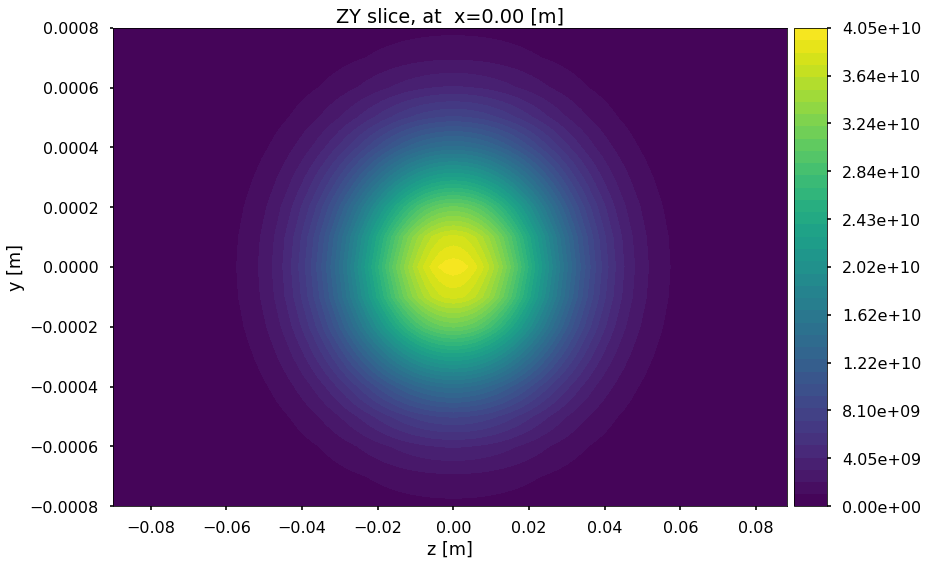

In [7]:
# plot the laser pulse envelope in a z-y plane that intersects the x=0 axis

# Turn on print statements for a particular file, a specified module, or *all* rslaser modules
#pkdebug.init(control='gauss_hermite.py')
#pkdebug.init(control='rspulse')
#pkdebug.init(control='rslaser')

if plot_2d_zy_envelope:
    
    # longitudinal resolution
    z_res = 16
    del_z = LP.envelope.tau_fwhm * scipy.constants.c / z_res
    z_max = 3. * LP.envelope.tau_fwhm * scipy.constants.c
    z_min = -z_max
    numZ = int((z_max - z_min) / del_z) + 1
    
    # transverse resolution
    y_res = 4
    del_y = LP.envelope.w0 / y_res
    y_max = 2. * LP.envelope.w0
    y_min = -y_max
    numY = int((y_max - y_min) / del_y) + 1

    # create the horiontal (z) and vertical (y) arrays
    zArr = np.zeros(numZ)
    yArr = np.zeros(numY)

    for i in range(numZ):
        zArr[i] = z_min + i * del_z

    for i in range(numY):
        yArr[i] = y_min + i * del_y

    # Choose value of x
    xValue = 0.

    with plt.style.context(('seaborn-poster')):
        fig = plt.figure()
        ax = fig.gca()
        plot_fields.plot_2d_zy(zArr, yArr, LP.envelope, ax, _x=xValue, _time_explicit=False, _nlevels=40)

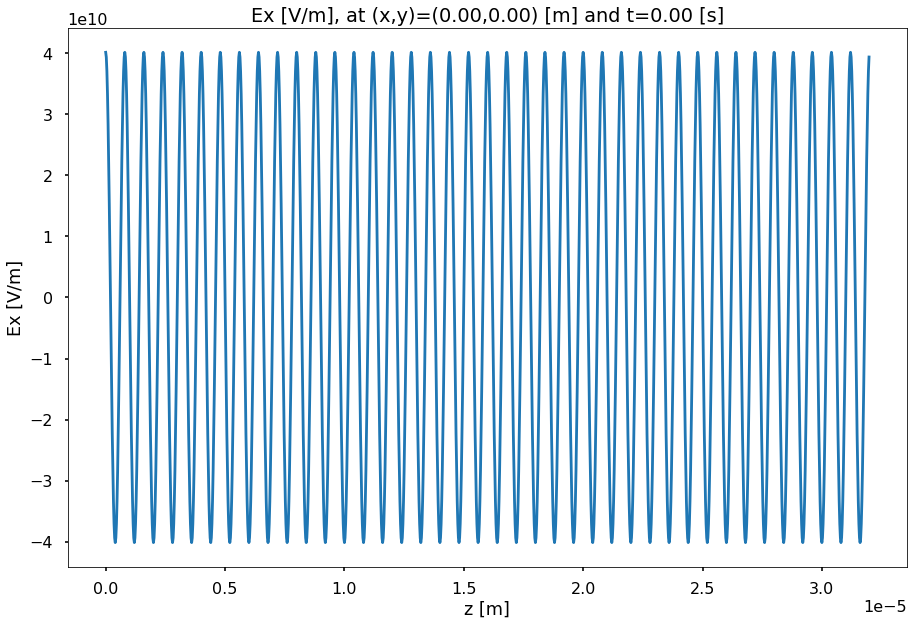

In [8]:
# plot a lineout of Ex along z
# we are assuming linear polarization along the x-axis
# the time-dependent oscillations will be included

# Turn on print statements for a particular file, a specified module, or *all* rslaser modules
#pkdebug.init(control='gauss_hermite.py')
#pkdebug.init(control='rspulse')
#pkdebug.init(control='rslaser')

if plot_1d_z_explicit:
    z_max = 40. * LP.envelope.lambda0
    z_min = 0.

    # resolution
    z_res = 32
    del_z = lambda0 / z_res
    num_pts = int((z_max - z_min) / del_z)
#    print('\n  num_pts = ', num_pts)

    z_vals = np.zeros(num_pts)
    for ind in range(num_pts):
        z_vals[ind] = z_min + ind*del_z
    
    x_val = 0.
    y_val = 0.
    t_val = 0.
    time_explicit = True

    with plt.style.context(('seaborn-poster')):
        fig = plt.figure()
        ax = fig.gca()
        plot_fields.plot_1d_z(z_vals, LP.envelope, ax, x_val, y_val, t_val, time_explicit)

    plt.tight_layout()

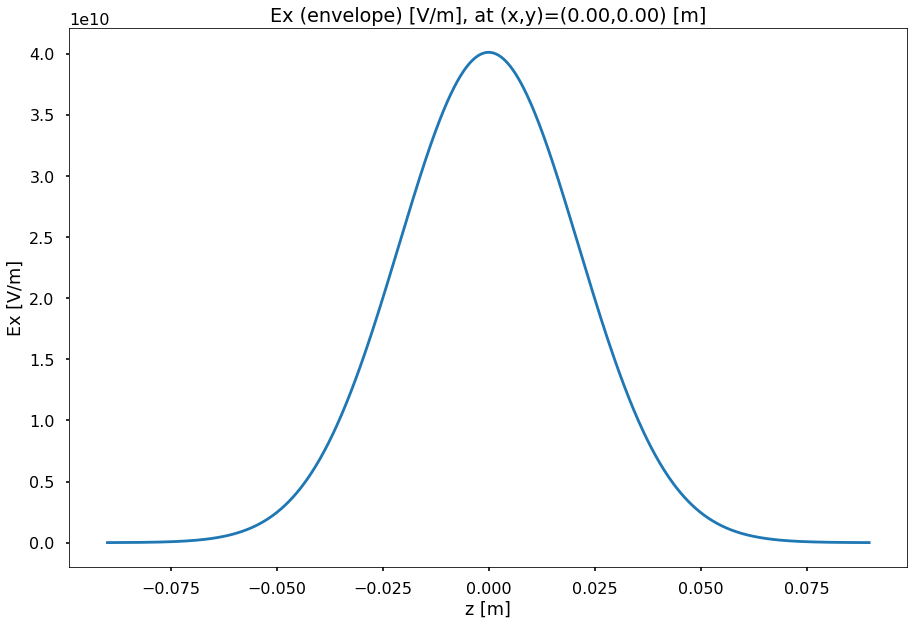

In [9]:
# plot a lineout of Ex along z
# we are assuming linear polarization along the x-axis
# this time, we plot only the envelope

# Turn on print statements for a particular file, a specified module, or *all* rslaser modules
#pkdebug.init(control='gauss_hermite.py')
#pkdebug.init(control='rspulse')
#pkdebug.init(control='rslaser')

if plot_1d_z_envelope:
    z_max = 3. * LP.envelope.tau_fwhm * scipy.constants.c
    z_min = -z_max

    # resolution
    z_res = 4
    del_z = LP.envelope.w0 / z_res
    num_pts = int((z_max - z_min) / del_z)
    # print('\n  num_pts = ', num_pts)

    z_vals = np.zeros(num_pts)
    for ind in range(num_pts):
        z_vals[ind] = z_min + ind*del_z
    
    x_val = 0.
    y_val = 0.
    t_val = 0.
    time_explicit = False

    with plt.style.context(('seaborn-poster')):
        fig = plt.figure()
        ax = fig.gca()
        plot_fields.plot_1d_z(z_vals, LP.envelope, ax, x_val, y_val, t_val, time_explicit)

    plt.tight_layout()

In [10]:
# let's create an ultra-short, strongly diverging laser pulse

if plot_2d_zr_explicit or plot_2d_zr_envelope:
    data2 = data_in.copy()
    
    data2.w0 = 400. * (data2.lambda0)
    data2.tau_fwhm = 10. * (data2.lambda0) / scipy.constants.c
    _k0 = constants.TWO_PI/(data2.lambda0)
    _zR = 0.5 * _k0 * (data2.w0)**2
    data2.z_waist = -12.*_zR   # this choice maximizes the radius of curvature
    data2.z_center = 0.
    data2.d_to_w = z_waist - z_center
    
#    print('w0 = ', data2.w0)
#    print('lambda0 = ', data2.lambda0)
#    print('_k0 = ', _k0, '; should be equal to: ', 2.*math.pi/(data2.lambda0))
#    print('_zR = ', _zR)
    
    z_opt = abs(data2.z_waist)
    invR = z_opt / (z_opt**2 + _zR**2)
    _wZ = data2.w0 * math.sqrt(1+(z_opt/_zR)**2)
    rSq_max = 4.*_wZ**2
#    print('_wZ = ', _wZ)
#    print('invR = ', invR)
#    print('rSq_max = ', rSq_max)
#    print("0.5 * _k0 * rSq_max / R = ", 0.5*_k0*invR*rSq_max)


In [11]:
if plot_2d_zr_explicit or plot_2d_zr_envelope:
    # instantiate a 2nd laser pulse (takes a few seconds)
    LP2 = pulse.LaserPulse(data2)

In [ ]:
# plot Er in the z-r plane
# we are assuming circular polarization

# Turn on print statements for a particular file, a specified module, or *all* rslaser modules
#pkdebug.init(control='gauss_hermite.py')
#pkdebug.init(control='rspulse')
#pkdebug.init(control='rslaser')

if plot_2d_zr_explicit:
    
    # longitudinal resolution
    hres = 32
    dh = LP2.envelope.lambda0 / hres

    # specify the horizontal min's and max's
    zrMinH = -18. * LP2.envelope.lambda0
    zrMaxH =  18. * LP2.envelope.lambda0

    # specify the number of horizontal mesh points
    zrNumH = int((zrMaxH - zrMinH) / dh) + 1
#    print('zrNumH = ', zrNumH)

    # specify the vertical min's and max's
    zrMaxV = 2.0 * LP2.envelope.w0 * math.sqrt(1+(LP2.envelope.z_waist/LP2.envelope.zR)**2)
    zrMinV = 0.
    
    # vertical resolution
    vres = 8
    dv = LP2.envelope.w0 / vres

    # specify the number of vertical mesh points
    zrNumV = int((zrMaxV - zrMinV) / dv) + 1
#    print('zrMaxV = ', zrMaxV)
#    print('zrNumV = ', zrNumV)

    # create the horiontal (z) and vertical (y) arrays
    zArr = np.zeros(zrNumH)
    rArr = np.zeros(zrNumV)

    for i in range(zrNumH):
        zArr[i] = zrMinH + i * dh

    for i in range(zrNumV):
        rArr[i] = i * dv

    # Choose values of t for plot
    tValue = 0.

    with plt.style.context(('seaborn-poster')):
        fig = plt.figure()
        ax = fig.gca()
        plot_fields.plot_2d_zr(zArr, rArr, LP2.envelope, ax, _t=tValue, _time_explicit=True, _nlevels=80)